In [1]:
import logging
import os

import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pyro

from utils import *

/home/wanhr/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
local_ip = "10.215.173.1"
dl_pkts = np.zeros([0, 3])
ul_pkts = np.zeros([0, 3])

for i in [1]:
  filename = "~/Documents/data/cos513/5G_Traffic_Datasets/Game_Streaming/GeForce_Now/GeForce_Now_{}.csv".format(i)

  df = load_csv(filename)
  # stats_src_ip(df)
  # stats_dst_ip(df)
  dl_data = extract_dl_pkt_interval_time(df, local_ip)
  ul_data = extract_ul_pkt_interval_time(df, local_ip)
  dl_pkts = np.concatenate((dl_pkts, dl_data), axis=0)
  ul_pkts = np.concatenate((ul_pkts, ul_data), axis=0)
  print(dl_pkts.shape)
  print(ul_pkts.shape)
  # dl_pkts = extract_dl_pkt_interval_time(df, local_ip)
  # ul_pkts = extract_ul_pkt_interval_time(df, local_ip)

(3430592, 3)
(526743, 3)


In [ ]:
FONT_SIZE = 35
plt.rcParams["font.size"] = FONT_SIZE


In [4]:
dl_pkt_interval = dl_pkts[dl_pkts[:, 0] < 0.05, :]
ul_pkt_interval = ul_pkts[ul_pkts[:, 0] < 0.05, :]

dl_pkt_interval[:, 0] = dl_pkt_interval[:, 0] * 1000
ul_pkt_interval[:, 0] = ul_pkt_interval[:, 0] * 1000

dl_count, dl_bins_count = np.histogram(dl_pkt_interval[:, 0], bins=1000) 
dl_pdf = dl_count / sum(dl_count) 
dl_cdf = np.cumsum(dl_pdf) 

ul_count, ul_bins_count = np.histogram(ul_pkt_interval[:, 0], bins=1000) 
ul_pdf = ul_count / sum(ul_count) 
ul_cdf = np.cumsum(ul_pdf) 

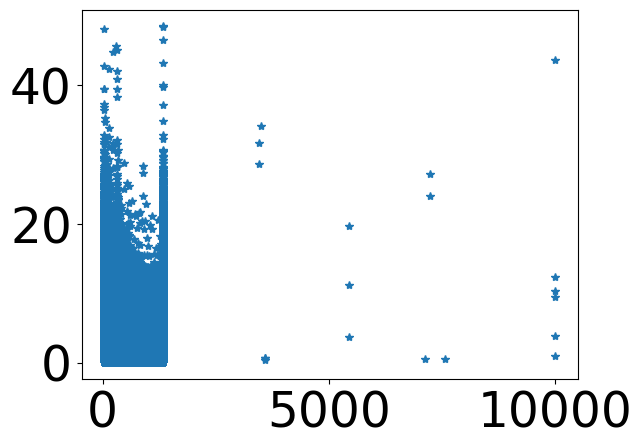

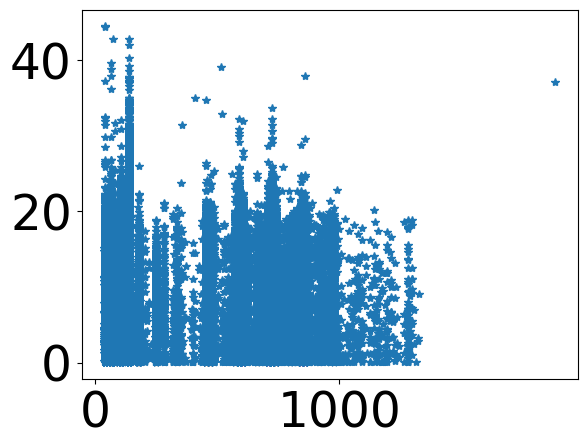

In [5]:
plt.figure()
plt.plot(dl_pkt_interval[:, 2], dl_pkt_interval[:, 0], '*')

plt.figure()
plt.plot(ul_pkt_interval[:, 2], ul_pkt_interval[:, 0], "*")

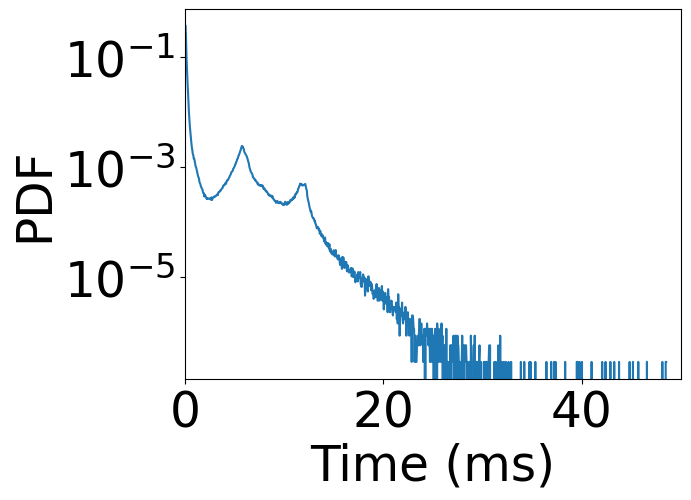

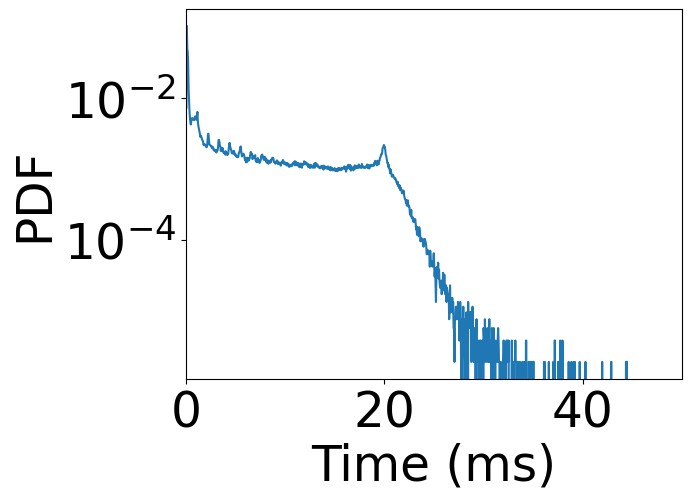

In [6]:
plt.figure()
plt.plot(dl_bins_count[1:], dl_pdf)
plt.xlim([0, 50])
plt.yscale("log")
plt.xlabel("Time (ms)")
plt.ylabel("PDF")
# plt.title("Downlink pkt inter-arrival time")

plt.figure()
plt.plot(ul_bins_count[1:], ul_pdf)
plt.xlim([0, 50])
plt.yscale("log")
plt.xlabel("Time (ms)")
plt.ylabel("PDF")
# plt.title("Uplink pkt inter-arrival time")

plt.show()

In [7]:
train = torch.tensor(dl_pkt_interval, dtype=torch.float)
pkt_interval, time, pkt_size = train[:, 0], train[:, 1], train[:, 2]

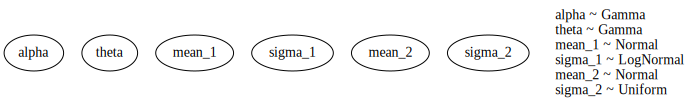

In [8]:
import pyro.distributions as dist
import pyro.distributions.constraints as constraints

# def categorical_possion()

def model(pkt_size, pkt_interval=None):
    alpha = pyro.sample("alpha", dist.Gamma(1., 1.))
    theta = pyro.sample("theta", dist.Gamma(1., 1.))
    gamma = dist.Gamma(alpha, theta)

    mean_1 = pyro.sample("mean_1", dist.Normal(5, 2))
    sigma_1 = pyro.sample("sigma_1", dist.LogNormal(0., 0.05))
    gaussian_1 = dist.Normal(mean_1, sigma_1)

    mean_2 = pyro.sample("mean_2", dist.Normal(12, 2))
    sigma_2 = pyro.sample("sigma_2", dist.Uniform(0., 0.05))
    gaussian_2 = dist.Normal(mean_2, sigma_2)

    cat_dist = dist.OneHotCategorical(torch.Tensor([0.7, 0.2, 0.1]))
    y = cat_dist.sample()

    gamma_samp = gamma.sample()
    gaussian_samp_1 = gaussian_1.sample()
    gaussian_samp_2 = gaussian_2.sample()
    
    with pyro.plate("data", len(time)):
        return y[0] * gamma_samp + y[1] * gaussian_samp_1 + y[2] * gaussian_samp_2

pyro.render_model(model, model_args=(pkt_size, pkt_interval), render_distributions=True)

In [9]:
def custom_guide(pkt_size, pkt_interval=None):
    alpha_alpha = pyro.param('alpha_alpha', lambda: torch.tensor(1.),
                             constraint=constraints.positive)
    alpha_theta = pyro.param('alpha_theta', lambda: torch.tensor(1.),
                             constraint=constraints.positive)
    alpha = pyro.sample('alpha', dist.Gamma(alpha_alpha, alpha_theta))

    theta_alpha = pyro.param('theta_alpha', lambda: torch.tensor(1.),
                             constraint=constraints.positive)
    theta_theta = pyro.param('theta_theta', lambda: torch.tensor(1.),
                             constraint=constraints.positive)
    theta = pyro.sample('theta', dist.Gamma(theta_alpha, theta_theta))

    mean_1_loc = pyro.param('mean_1_loc', lambda: torch.tensor(5. ))
    sigma_1_loc = pyro.param('sigma_1_loc', lambda: torch.tensor(0.))
    mean_1 = pyro.sample('mean_1', dist.Normal(mean_1_loc, torch.tensor(0.05)))
    sigma_1 = pyro.sample('sigma_1', dist.LogNormal(sigma_1_loc, torch.tensor(0.005)))

    mean_2_loc = pyro.param('mean_2_loc', lambda: torch.tensor(12. ))
    sigma_2_loc = pyro.param('sigma_2_loc', lambda: torch.tensor(0.))
    mean_2 = pyro.sample('mean_2', dist.Normal(mean_2_loc, torch.tensor(0.05)))
    sigma_2 = pyro.sample('sigma_2', dist.LogNormal(sigma_2_loc, torch.tensor(0.005)))

    # weight_1 = pyro.param('weight_1', lambda: torch.tensor(0.9),
    #                       constraint=constraints.positive)
    # weight_2 = pyro.param('weight_2', lambda: torch.tensor(0.05),
    #                       constraint=constraints.positive)
    # weight_3 = pyro.param('weight_3', lambda: torch.tensor(0.05),
    #                       constraint=constraints.positive)
    # cat = dist.OneHotCategorical(torch.Tensor([weight_1, weight_2, weight_3]))
    # y = pyro.sample('y', cat)

    return {'alpha': alpha, 'theta': theta, 'mean_1': mean_1, 'sigma_1': sigma_1, 
            'mean_2': mean_2, 'sigma_2': sigma_2}

In [10]:
def guide_map(pkt_size, pkt_interval=None):
  alpha_alpha = pyro.param('alpha_alpha', lambda: torch.tensor(1.),
                             constraint=constraints.unit_interval)
  alpha_theta = pyro.param('alpha_theta', lambda: torch.tensor(1.),
                            constraint=constraints.unit_interval)
  alpha = pyro.sample('alpha', dist.Gamma(alpha_alpha, alpha_theta))

  theta_alpha = pyro.param('theta_alpha', lambda: torch.tensor(1.),
                            constraint=constraints.unit_interval)
  theta_theta = pyro.param('theta_theta', lambda: torch.tensor(1.),
                            constraint=constraints.unit_interval)
  theta = pyro.sample('theta', dist.Gamma(theta_alpha, theta_theta))

  mean_1_loc = pyro.param('mean_1_loc', lambda: torch.tensor(5. ))
  sigma_1_loc = pyro.param('sigma_1_loc', lambda: torch.tensor(0.))
  mean_1 = pyro.sample('mean_1', dist.Normal(mean_1_loc, torch.tensor(0.05)))
  sigma_1 = pyro.sample('sigma_1', dist.Uniform(0, torch.tensor(0.005)))

  mean_2_loc = pyro.param('mean_2_loc', lambda: torch.tensor(12. ))
  sigma_2_loc = pyro.param('sigma_2_loc', lambda: torch.tensor(0.))
  mean_2 = pyro.sample('mean_2', dist.Normal(mean_2_loc, torch.tensor(0.05)))
  sigma_2 = pyro.sample('sigma_2', dist.Uniform(0, torch.tensor(0.005)))

  # weight_1 = pyro.param('weight_1', lambda: torch.tensor(0.9),
  #                       constraint=constraints.positive)
  # weight_2 = pyro.param('weight_2', lambda: torch.tensor(0.05),
  #                       constraint=constraints.positive)
  # weight_3 = pyro.param('weight_3', lambda: torch.tensor(0.05),
  #                       constraint=constraints.positive)
  # cat = dist.OneHotCategorical(torch.Tensor([weight_1, weight_2, weight_3]))
  # y = pyro.sample('y', cat)

  return {'alpha': alpha, 'theta': theta, 'mean_1': mean_1, 'sigma_1': sigma_1, 
          'mean_2': mean_2, 'sigma_2': sigma_2}

In [11]:
def train(model, guide, lr=0.02, n_steps=5000):
  pyro.clear_param_store()
  adam_params = {"lr": lr}
  adam = pyro.optim.Adam(adam_params)
  svi = pyro.infer.SVI(model, guide, adam, loss=pyro.infer.Trace_ELBO())

  for step in range(n_steps):
      loss = svi.step(data)
      if step % 50 == 0:
          print('[iter {}]  loss: {:.4f}'.format(step, loss))

Step: 0, Elbo loss: 8355.21698872
Step: 100, Elbo loss: 7895.417582064867
Step: 200, Elbo loss: 5627.290628254414
Step: 300, Elbo loss: 5875.129090169212
Step: 400, Elbo loss: 8544.581468820572
Step: 500, Elbo loss: 9926.641991972923
Step: 600, Elbo loss: 7272.864054754376
Step: 700, Elbo loss: 6150.5826262533665
Step: 800, Elbo loss: 6123.027777254581
Step: 900, Elbo loss: 6876.232217103243
Step: 1000, Elbo loss: 7966.98380548507
Step: 1100, Elbo loss: 6128.582007616758
Step: 1200, Elbo loss: 17833.907285302877
Step: 1300, Elbo loss: 5761.854586482048
Step: 1400, Elbo loss: 5939.8767612576485
Step: 1500, Elbo loss: 6877.4623519182205
Step: 1600, Elbo loss: 10145.327922876924
Step: 1700, Elbo loss: 8077.751280878554
Step: 1800, Elbo loss: 5745.201196089387
Step: 1900, Elbo loss: 6428.780684649944
Step: 2000, Elbo loss: 7429.633204758167
Step: 2100, Elbo loss: 5845.877414852381
Step: 2200, Elbo loss: 6047.857720732689
Step: 2300, Elbo loss: 6816.054560780525
Step: 2400, Elbo loss: 9358.

Text(0, 0.5, 'ELBO loss')

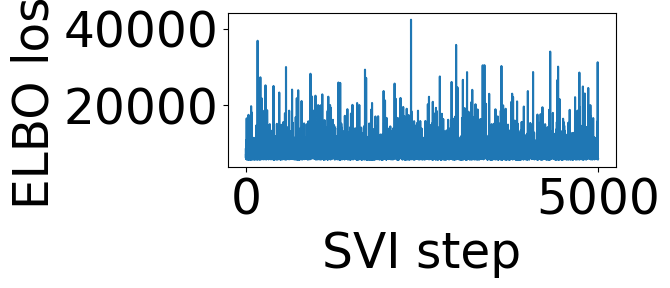

In [13]:
smoke_test = ('CI' in os.environ)

pyro.clear_param_store()

# These should be reset each training loop.
adam = pyro.optim.Adam({"lr": 0.02})  # Consider decreasing learning rate.
elbo = pyro.infer.Trace_ELBO()
svi = pyro.infer.SVI(model, guide_map, adam, elbo)

losses = []
for step in range(5000 if not smoke_test else 2):  # Consider running for more steps.
    loss = svi.step(pkt_size, pkt_interval)
    losses.append(loss)
    if step % 100 == 0:
        print("Step: {}, Elbo loss: {}".format(step, loss))

plt.figure(figsize=(5, 2))
plt.plot(losses)
plt.xlabel("SVI step")
plt.ylabel("ELBO loss")

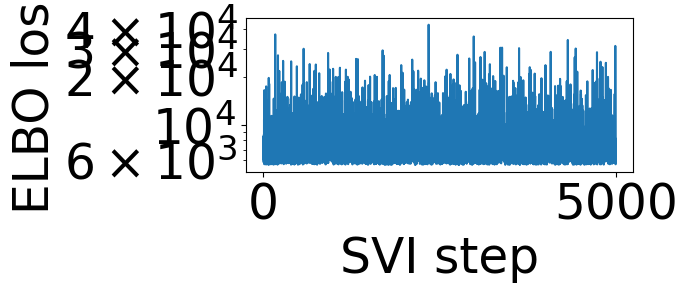

In [14]:
plt.figure(figsize=(5, 2))
plt.plot(losses)
plt.yscale("log")
plt.xlabel("SVI step")
plt.ylabel("ELBO loss");

In [15]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name).data.cpu().numpy())

alpha_alpha 0.9999988
alpha_theta 0.9999999
theta_alpha 0.9999999
theta_theta 0.99999964
mean_1_loc 5.022357
sigma_1_loc 0.0
mean_2_loc 12.018251
sigma_2_loc 0.0


In [16]:
res = []
for i in range(10000):
  predictive = pyro.infer.Predictive(model, guide=auto_guide, num_samples=1)
  svi_samples = predictive(pkt_size, pkt_interval=None)

  gamma_samp = dist.Exponential(svi_samples['alpha'][0]).sample()
  gaussian_samp_1 = dist.Normal(svi_samples['mean_1'][0], svi_samples['sigma_1'][0]).sample()
  gaussian_samp_2 = dist.Normal(svi_samples['mean_2'][0], svi_samples['sigma_2'][0]).sample()
  cat_dist = dist.OneHotCategorical(torch.Tensor([0.9, 0.05, 0.05]))
  y = cat_dist.sample()
  res.append(y[0] * gamma_samp + y[1] * gaussian_samp_1 + y[2] * gaussian_samp_2)

print(res)

[tensor(0.0351), tensor(2.3249), tensor(0.1028), tensor(2.1367), tensor(-1.0832), tensor(0.2051), tensor(0.3851), tensor(-0.8604), tensor(0.2212), tensor(0.4138), tensor(0.4935), tensor(-0.1673), tensor(2.9025), tensor(0.0211), tensor(1.9955), tensor(1.1503), tensor(1.1935), tensor(0.1379), tensor(1.4596), tensor(0.3037), tensor(0.0085), tensor(0.3373), tensor(1.0630), tensor(0.1786), tensor(0.3306), tensor(0.6224), tensor(0.2667), tensor(1.3821), tensor(1.1151), tensor(0.3438), tensor(1.6079), tensor(0.4912), tensor(0.4517), tensor(0.4353), tensor(0.2496), tensor(2.3521), tensor(1.5297), tensor(0.5159), tensor(0.0432), tensor(0.2709), tensor(0.1166), tensor(2.0060), tensor(0.7322), tensor(0.0327), tensor(0.7418), tensor(1.3697), tensor(3.4139), tensor(0.1960), tensor(-0.2592), tensor(0.9546), tensor(3.0382), tensor(0.3118), tensor(0.0186), tensor(0.1793), tensor(0.4797), tensor(0.0828), tensor(0.2402), tensor(2.1146), tensor(1.3920), tensor(0.4418), tensor(1.2350), tensor(0.3435), ten

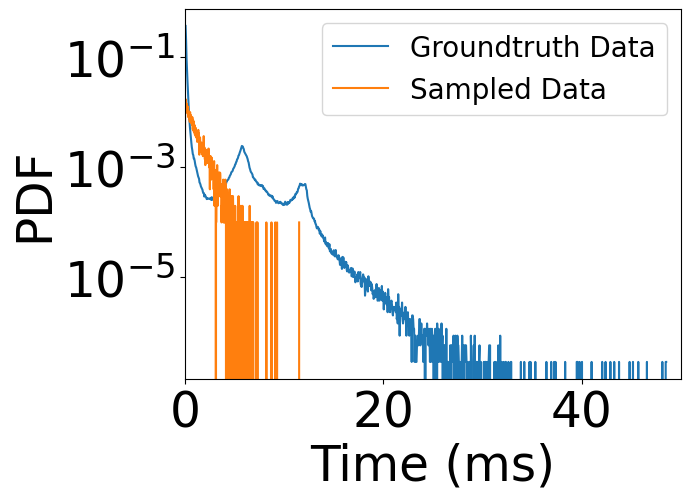

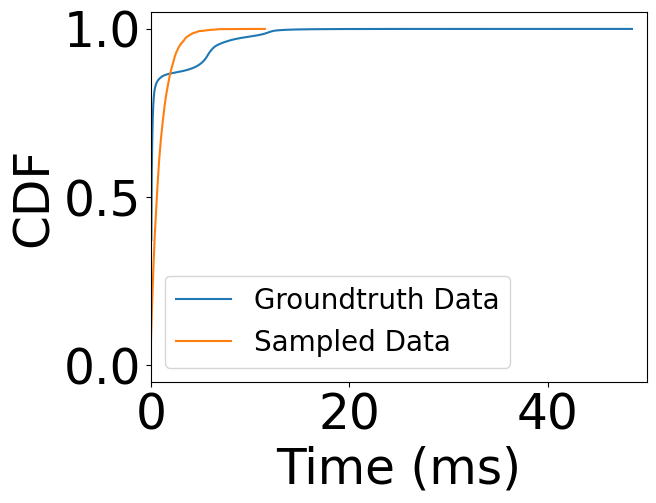

In [17]:
res = np.array(res)

res_count, res_bins_count = np.histogram(res, bins=1000) 
res_pdf = res_count / sum(res_count) 
res_cdf = np.cumsum(res_pdf) 

plt.figure()
plt.plot(dl_bins_count[1:], dl_pdf, label="Groundtruth Data")
plt.yscale("log")
plt.xlabel("Time (ms)")
plt.ylabel("PDF")

# plt.figure()
plt.plot(res_bins_count[1:], res_pdf, label="Sampled Data")
plt.xlim([0, 50])
plt.yscale("log")
plt.xlabel("Time (ms)")
plt.ylabel("PDF")
plt.legend(prop={'size': 20})

plt.figure()
plt.plot(dl_bins_count[1:], dl_cdf, label="Groundtruth Data")
# plt.yscale("log")

# plt.figure()
plt.plot(res_bins_count[1:], res_cdf, label="Sampled Data")
# plt.yscale("log")
plt.xlabel("Time (ms)")
plt.ylabel("CDF")
plt.xlim([0, 50])
plt.legend(prop={'size': 20})

plt.show()